# Lithology classification using Hugging Face, part 2

- toc: true 
- badges: true
- comments: true
- categories: [hugging-face, NLP, lithology]
- author: J-M


# About

This is a continuation of [Lithology classification using Hugging Face, part 1](https://jmp75.github.io/work-blog/hugging-face/nlp/lithology/2022/06/01/lithology-classification-hugging-face.html).

We saw in the previous post that the Namoi lithology logs data had their primary (major) lithology mostly completed. A substantial proportion had None nevertheless, despite descriptions that looked like they would obviously lead to a categorisation. There were many labels, with a long-tailed frequency histogram.

# Kernel installation

Note that mamba seems to not work on `conda install -c huggingface -c conda-forge datasets`; just returns immediately with no output that I can see. Pity because conda install is taking minutes to solve the environment. 

```sh
conda install --force-reinstall mamba -c conda-forge
# led to conflicts! Probably related to my installing grayskull and shyaml recently in the base environment. This seems to prevent the instalation of the latest vesion of mamba
```

```text
UnsatisfiableError: The following specifications were found to be incompatible with a past
explicit spec that is not an explicit spec in this operation (openssl):

  - mamba -> conda[version='4.6.*,<4.13.0|4.6.*|4.7.*,<4.13.0|>=4.7.12,<4.13.0|>=4.8,<4.13.0|>=4.7.12,<4.8']
  - mamba -> openssl[version='>=1.1.1f,<1.1.2a|>=1.1.1g,<1.1.2a|>=1.1.1h,<1.1.2a|>=1.1.1i,<1.1.2a|>=1.1.1j,<1.1.2a|>=1.1.1k,<1.1.2a|>=1.1.1l,<1.1.2a|>=1.1.1n,<1.1.2a|>=1.1.1o,<1.1.2a']
  - mamba -> openssl[version='>=1.1.1o,<1.1.2a'] -> ca-certificates
  - mamba -> pypy3.7[version='>=7.3.7'] -> openssl[version='1.0.*|>=1.0.2o,<1.0.3a|>=1.0.2p,<1.0.3a|>=1.1.1a,<1.1.2a|>=1.1.1e,<1.1.2a|>=3.0.0,<4.0a0|>=3.0.3,<4.0a0|>=3.0.2,<4.0a0|>=1.1.1d,<1.1.2a']

The following specifications were found to be incompatible with each other:

Output in format: Requested package -> Available versions
```

`conda remove shyaml grayskull conda-build` In the end figured out I needed `conda install -c conda-forge conda=4.12.0`



```sh
conda create -n hf python=3.9 -c conda-forge
conda install --name hf ipykernel matplotlib
conda activate hf
python -m ipykernel install --user --name hf --display-name "Hugging Face"
conda install -c huggingface -c conda-forge datasets transformers
```

```sh
# /home/per202/src/learning-notes/ml/fastai/log.md
cd /home/per202/src/learning-notes/ml/fastai
myenv=hf
mamba install -n $myenv -c pytorch -c conda-forge --file nbdev.txt
mamba install -n $myenv pytorch=1.11 -c pytorch -c nvidia -c conda-forge
mamba install -n $myenv torchvision torchaudio -c pytorch -c nvidia -c conda-forge
mamba install -n $myenv -c conda-forge sentencepiece
```

<AxesSubplot:xlabel='token'>

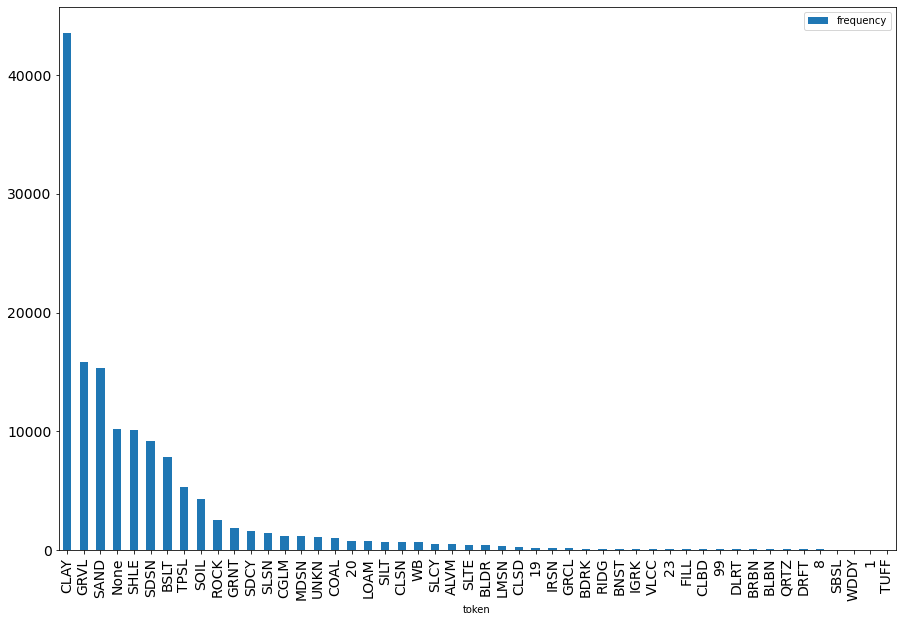

In [1]:
#hide
import pandas as pd
from pathlib import Path
fn =  Path('~').expanduser() / "data/ela/shp_namoi_river/NGIS_LithologyLog.csv"
litho_logs = pd.read_csv(fn, dtype={'FromDepth': str, 'ToDepth': str, 'MajorLithCode': str, 'MinorLithCode': str})
MAJOR_CODE='MajorLithCode'
MINOR_CODE='MinorLithCode'
DESC='Description'

#from ela.textproc import token_freq, plot_freq

from collections import Counter
def token_freq(tokens, n_most_common = 50):
    list_most_common=Counter(tokens).most_common(n_most_common)
    return pd.DataFrame(list_most_common, columns=["token","frequency"])

def plot_freq(dataframe, y_log = False, x='token', figsize=(15,10), fontsize=14):
    """Plot a sorted histogram of work frequencies

    Args:
        dataframe (pandas dataframe): frequency of tokens, typically with colnames ["token","frequency"]
        y_log (bool): should there be a log scale on the y axis
        x (str): name of the columns with the tokens (i.e. words)
        figsize (tuple):
        fontsize (int):

    Returns:
        barplot: plot

    """
    p = dataframe.plot.bar(x=x, figsize=figsize, fontsize=fontsize)
    if y_log:
        p.set_yscale("log", nonposy='clip')
    return p


litho_classes=litho_logs[MAJOR_CODE].values
df_most_common= token_freq(litho_classes, 50)
plot_freq(df_most_common)



* For the sake of applying HF, can I reduce the number of target labels.
* unbalanced data sets: https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/ 


In [2]:
import numpy as np
def sample_desc_for_code(major_code, n=50, seed=None):
    is_code = litho_logs[MAJOR_CODE] == major_code
    coded = litho_logs.loc[is_code][DESC]
    if seed is not None:
        np.random.seed(seed)
    return coded.sample(n=50)

In [3]:
sample_desc_for_code('UNKN', seed=123)

134145     (UNKNOWN), NO SAMPLE COLLECTED DUE TO WATER LOSS
134715    (UNKNOWN); COULD NOT BE LOGGED BECAUSE NO CUTT...
122303                                          GREY SHALEY
133856                                              NOMINAL
134378                                                 None
133542                                              DRILLER
122258                                        WATER BEARING
127916                                         WATER SUPPLY
133676                                              DRILLER
134399                                              DRILLER
134052                                              DRILLER
128031                         VERY SANDY STONES SOME LARGE
134140                                       SAMPLE MISSING
122282                              REDDISH YELLOW VOLCANIC
133623                                    WHITE CRYSTALLINE
134505                                              MISSING
133694                                  

## Minor (secondary) lithology codes

In [4]:
labels_kept = df_most_common['token'][:17].values
labels_kept = labels_kept[labels_kept != 'None']
labels_kept

array(['CLAY', 'GRVL', 'SAND', 'SHLE', 'SDSN', 'BSLT', 'TPSL', 'SOIL',
       'ROCK', 'GRNT', 'SDCY', 'SLSN', 'CGLM', 'MDSN', 'UNKN', 'COAL'],
      dtype=object)

In [5]:
kept = [x in labels_kept for x in litho_classes]

In [6]:
litho_logs_kept = litho_logs[kept]
litho_logs_kept.sample(10)

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,MinorLithCode,Description,Source,LogType,OgcFidTemp
70655,526412,10072593,GW031851.1.1,None,UNK,53.94,59.13,None,None,CLAY,NaN,CLAY SANDY,UNK,1,9308381
7173,64072,10043001,GW001815.1.1,None,UNK,31.39,44.5,None,None,SHLE,NaN,SHALE,UNK,1,8732384
30076,197788,10152523,GW099036.1.1,None,UNK,181.0,228.0,None,None,SHLE,NaN,"SHALE: GREY, FINE",UNK,1,8870150
93967,701859,10105392,GW031140.1.1,None,UNK,0.0,8.84,None,None,SOIL,NaN,SOIL CLAY,UNK,1,9327759
115538,803595,10099300,GW970770.1.1,None,UNK,36.6,38.1,None,None,SAND,NaN,"SAND; FINE TO COARSE, BROWN",UNK,1,9435886
107173,762000,10122945,GW018629.1.1,None,UNK,72.54,74.37,None,None,SDSN,NaN,SANDSTONE YELLOW HARD,UNK,1,9389679
106769,760370,10111007,GW026576.1.1,None,UNK,65.23,71.32,None,None,SDSN,NaN,SANDSTONE WATER SUPPLY,UNK,1,9388007
13553,114744,10116235,GW022175.1.1,None,UNK,37.8,39.01,None,None,GRVL,NaN,GRAVEL FINE-COARSE,UNK,1,8784472
142398,971715,10074454,GW901230.1.1,None,UNK,20.0,24.0,None,None,GRVL,NaN,GRAVEL,UNK,1,9567221
9664,85061,10043586,GW011521.1.1,None,UNK,12.19,20.73,None,None,CLAY,NaN,CLAY YELLOW GRAVEL,UNK,1,8753973


In [7]:
def sample_major_lithocode(dframe, code, n=10000, seed=None):
    x = litho_logs_kept[litho_logs_kept[MAJOR_CODE] == code]
    replace = n > len(x)
    return x.sample(n=n, replace=replace, random_state=seed)

In [8]:
sample_major_lithocode(litho_logs_kept, 'CLAY', n=10, seed=0)

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,MinorLithCode,Description,Source,LogType,OgcFidTemp
106742,760246,10144429,GW030307.1.1,279.5,NGS,54.3,72.2,225.2,207.3,CLAY,NaN,CLAY LIGHT BROWN GRAVEL,UNK,1,9387877
138850,950521,10147004,GW036015.2.2,236.0,NGS,73.15,74.676,162.85,161.324,CLAY,NaN,"CLAY; AS ABOVE, MORE MICACEOUS & FINE GRAVEL (...",?? - WC&IC,2,9543085
30006,197243,10049338,GW062392.1.1,None,UNK,63.0,64.0,None,None,CLAY,NaN,CLAY SANDY,UNK,1,8869540
3225,29304,10142901,GW014623.1.1,None,UNK,22.86,23.47,None,None,CLAY,NaN,CLAY SANDY,UNK,1,8696556
9795,86262,10121680,GW009977.1.1,None,UNK,39.01,42.67,None,None,CLAY,NaN,CLAY YELLOW PUGGY,UNK,1,8755205
49588,427460,10067562,GW964964.1.1,None,UNK,11.0,14.0,None,None,CLAY,NaN,CLAY,UNK,1,9199868
136116,943202,10055892,GW971627.1.1,None,UNK,14.0,20.0,None,None,CLAY,NaN,GREY WET CLAY,UNK,1,9534634
5723,50788,10049974,GW010017.1.1,None,UNK,14.02,24.38,None,None,CLAY,NaN,CLAY RED SANDY,UNK,1,8718677
94938,706287,10018922,GW022845.1.1,None,UNK,1.22,11.58,None,None,CLAY,NaN,CLAY,UNK,1,9332267
38277,287347,10132392,GW042735.1.1,None,UNK,0.75,6.0,None,None,CLAY,NaN,CLAY,UNK,1,8942094


In [9]:
balanced_litho_logs = [sample_major_lithocode(litho_logs_kept, code, n=10000, seed=0) for code in labels_kept]


In [10]:
balanced_litho_logs = pd.concat(balanced_litho_logs)

In [11]:
balanced_litho_logs.head()


,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,MinorLithCode,Description,Source,LogType,OgcFidTemp
106742,760246,10144429,GW030307.1.1,279.5,NGS,54.3,72.2,225.2,207.3,CLAY,NaN,CLAY LIGHT BROWN GRAVEL,UNK,1,9387877
138850,950521,10147004,GW036015.2.2,236.0,NGS,73.15,74.676,162.85,161.324,CLAY,NaN,"CLAY; AS ABOVE, MORE MICACEOUS & FINE GRAVEL (...",?? - WC&IC,2,9543085
30006,197243,10049338,GW062392.1.1,None,UNK,63.0,64.0,None,None,CLAY,NaN,CLAY SANDY,UNK,1,8869540
3225,29304,10142901,GW014623.1.1,None,UNK,22.86,23.47,None,None,CLAY,NaN,CLAY SANDY,UNK,1,8696556
9795,86262,10121680,GW009977.1.1,None,UNK,39.01,42.67,None,None,CLAY,NaN,CLAY YELLOW PUGGY,UNK,1,8755205


<AxesSubplot:xlabel='token'>

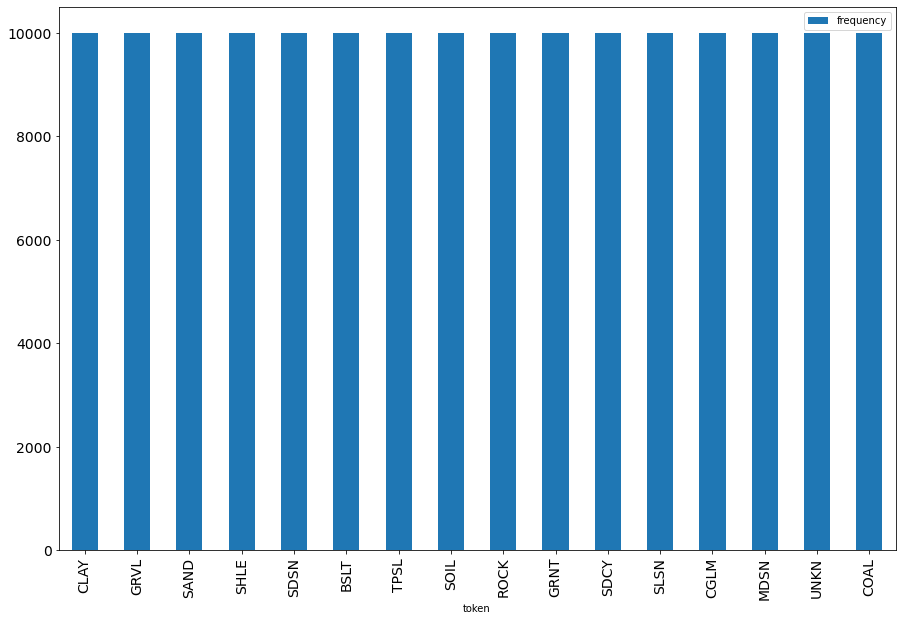

In [12]:
plot_freq(token_freq(balanced_litho_logs[MAJOR_CODE].values, 50))

In [13]:
from datasets import Dataset,DatasetDict

In [14]:
ds = Dataset.from_pandas(balanced_litho_logs)

In [15]:
ds

Dataset({
    features: ['OBJECTID', 'BoreID', 'HydroCode', 'RefElev', 'RefElevDesc', 'FromDepth', 'ToDepth', 'TopElev', 'BottomElev', 'MajorLithCode', 'MinorLithCode', 'Description', 'Source', 'LogType', 'OgcFidTemp', '__index_level_0__'],
    num_rows: 160000
})

In [16]:
model_nm = 'microsoft/deberta-v3-small'

In [17]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
tokz.tokenize('CLAY, VERY SANDY')

['▁C', 'LAY', ',', '▁VERY', '▁S', 'ANDY']

In [20]:
tokz.tokenize('clay, very sandy')

['▁clay', ',', '▁very', '▁sandy']

In [30]:
litho_logs_kept[DESC] = litho_logs_kept[DESC].str.lower()

/tmp/ipykernel_31571/2802429751.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  litho_logs_kept[DESC] = litho_logs_kept[DESC].str.lower()


In [28]:
litho_logs_kept[DESC]

0              soil sandy clay
1         basalt water bearing
2                      topsoil
3         gravel water bearing
4                slippery back
                  ...         
144506                    none
144507                    none
144508                    none
144509                    none
144510                 topsoil
Name: Description, Length: 123657, dtype: object

Well, no minor lithology codes, so this data set may not be a good start for multi-label classification. Still, I'll persist with this data set, and reassess later on

## Back to major lithology codes

What are the flavour of descriptions leading to the most frequent classes (CLAY, GRVL, etc.), as well as "None" 

In [12]:
is_clay = litho_logs[MAJOR_CODE] == 'CLAY'

In [13]:
clay_coded = litho_logs.loc[is_clay][DESC]

In [14]:
import numpy as np
np.random.seed(123)
clay_coded.sample(n=50)

144320                                                 CLAY
117387                                                 CLAY
18630                                                  CLAY
35565                                       CLAY SOME SANDY
61997                                                  CLAY
13533                                  CLAY SANDSTONE BANDS
117529                                          YELLOW CLAY
82290                                                  CLAY
73280                                       CLAY GREY SANDY
106748                                          CLAY STONEY
26265                                           CLAY YELLOW
16456                                                  CLAY
25032                                                  CLAY
9911                                                   CLAY
135852    CLAY, SANDY GRAVELLY, ORANGE BROWN, MEDIUM PLA...
30596                                                  CLAY
140698    CLAY, SANDY FAT; RED, DRY-MOIS

Nothing too surprising in this, very intuitive, though the tail suggests there may be a few outliers:

In [15]:
clay_coded.tail(10)

144386            CLAY; LIGHT BROWN, SOME LIGHT GREY, SILTY
144388                                          CLAY; BROWN
144391                                    CLAY; LIGHT BROWN
144393                                         CLAY - BROWN
144394         CLAY - LIGHT BROWN, EXTREMELY SANDY (COARSE)
144398    CONGLOMERATE - WEATHERED BUT STILL HOLDS TOGET...
144401                                          CLAY; BROWN
144402                                          CLAY - GREY
144488                                                 CLAY
144503                                                 None
Name: Description, dtype: object

Looking at the "sand" code:

In [16]:
def sample_desc_for_code(major_code, n=50, seed=None):
    is_code = litho_logs[MAJOR_CODE] == major_code
    coded = litho_logs.loc[is_code][DESC]
    if seed is not None:
        np.random.seed(seed)
    return coded.sample(n=50)

In [17]:
sample_desc_for_code('SAND', seed=123)

72256                         SAND GRAVEL FINE WATER SUPPLY
109345                                   SAND CLAYEY GRAVEL
66816                                     SAND WATER SUPPLY
85097     SAND - 70% UP TO 2MM, GRAVEL 10% 2-5MM, CLAY 2...
137476    SAND; LIGHT BROWN, MEDIUM TO COARSE, FINE GRAV...
29946                                     SAND GRAVEL DIRTY
37012                                COARSE SAND AND GRAVEL
135985                                                 SAND
74402              SAND WHITE GREY WELL SORTED WATER SUPPLY
42422                                           SAND GRAVEL
41225                                    SAND CLAYEY GRAVEL
50700                                                  SAND
33813                      BROWN SAND (VERY FINE TO MEDIUM)
38452                       SAND GRAVEL MEDIUM WATER SUPPLY
107707                                     SAND FINE-COARSE
51759     SAND; 60%, SILTY, FINE 10%, MEDIUM 20% & COARS...
102234                             SAND 

Rather straighforward, consistent and and intuitive

### Major lithology code "None"

This one is likely to be more curly and surprising. Let's see


In [18]:
sample_desc_for_code('None', seed=123)

131075                            W.B. BROWN SHALE
127170                      COARSE SAND AND GRAVEL
126145                                   BLUE CLAY
126889                         GREY AND BROWN CLAY
132179                             GREY BROWN CLAY
130033                            BROWN SANDY CLAY
123436                                      GRAVEL
128794                                        CLAY
128242                        SAND AND FINE GRAVEL
134156                                        None
129636                                 W.B. BASALT
122884                     LIGHT ORANGE SILTY CLAY
124580                                      SHALES
128684                                  W.B. SHALE
131120                             SAND AND GRAVEL
122690                              RED RIDGE CLAY
132319                                  BLACK SOIL
128528                                  BLACK CLAY
123646                                    MUDSTONE
129757                         

Well, it does not require a fully trained geologist to think there should be obvious primary lithology codes for many of these, so why is there "None" for these descriptions?

Not shown in the 50-odd sample above are descriptions which should indeed be unclassified (e.g. "no strata description")

This is also an occasion to note the less obvious information and complications in descriptive logs, compared to earlier categories:
  
* CALY as a typo for CLAY
* Slang terms and acronyms, e.g. "W.B." perhaps for "Weathered, broken"  
* Quantitative and qualitative attributes such as SAND; 60%, SILTY, FINE 10%, MEDIUM 20% & COARSE, which may be valuable for some types of classification 


In [19]:
sample_desc_for_code('SDSN', seed=123)

9423                                         SANDSTONE SOFT
117911            SANDSTONE, SILTY; AS ABOVE, QUARTZ (+60%)
6613                                         SAND ROCK GREY
20345                                   SANDSTONE GREY HARD
106885                                            SANDSTONE
139088           SANDSTONE; DARK GREY, COARSE GRAINED, HARD
5101                                       SANDSTONE ROTTEN
26561                                      SANDSTONE YELLOW
137304                                    SANDSTONE; COARSE
56627     SANDSTONE; GREY, FINE-MEDIUM GRAINED, MOD WEAK...
98974                          SANDSTONE WHITE WATER SUPPLY
87187                                             SANDSTONE
45141                 SANDSTONE, VERY PALE BROWN, HIGH CLAY
70015                                      SANDSTONE YELLOW
29492                                SANDSTONE WATER SUPPLY
92918                                             SANDSTONE
83555              SANDSTONE; LIGHT GREY

Now, what's with the weird numbers as lithology codes?

In [20]:
sample_desc_for_code('20', seed=123)

130369                           SANDY CLAY; BROWN (COARSE)
122444                                           CLAY SANDY
127761                                           CLAY SANDY
125771                                           SANDY CLAY
127783                                           CLAY SANDY
133014                SANDY CLAY AND CLAYEY SAND AND GRAVEL
124007                              BROWN & GREY SANDY CLAY
123445     CLAY LT BROWN GREY SANDY, MED-COARSE BROWN BANDS
122180                                           CLAY SANDY
127440                                           SANDY CLAY
131498                                           SANDY CLAY
127935                                       CLAY RED SANDY
129304                                           SANDY CLAY
130614                                          SANDY SHALE
125543                                           SANDY CLAY
125149                                           SANDY CLAY
124971                                SA

Interesting. There is a clear pattern. I know from my prior exposure that "Clayey sands" and "sandy clays" are not that uncommon (and gradations of mixes of sand and clay matter a great deal to estimate hydraulic conductivity).

## Next

This was the initial EDA. Next I'll  probably train a classifier on the major lithology code (or a subset thereof). I am keen to explore multi-label classification, but will have to decide whether to populate the secondary lithology code using regexp classification, or switch to a fully labelled dataset at some point.

This first post illustrated the need to have a look at data. This data was already collated and curated, and I have no doubt many people went through a lot of work to get there. But this may not be a fully labelled dataset amenable to be used for training a classifier. At least, not without further data preparation.